In [1]:
import sys
sys.path.append('../src/')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import scipy
from antenna import Antenna
import itertools
from tqdm import tqdm

In [2]:
with open("../config.json", 'r') as cfg:
    params = json.load(cfg)

antenna_params = params["antenna_params"]
opt_params = params["optimisation_params"]

In [144]:
antenna_params['N'] = 100

In [145]:
antenna_params["wavelengths"]=[1, 2]
antenna = Antenna(antenna_params)
antenna.set_objective(weights=[1.0, 1.0])
antenna.set_jacobian(weights=[1.0, 1.0])
antenna.set_hessian(weights=[1.0, 1.0])

In [146]:
np.sqrt(abs(min(np.linalg.eigvals(antenna.afs[0].conj().T@antenna.afs[0])) * min(np.linalg.eigvals(antenna.afs[1].conj().T@antenna.afs[1]))))

3.9606998738847275e-06

In [163]:
np.linalg.eigvals(antenna.afs[0].conj().T@antenna.afs[0])

array([1638.20689606+2.17850644e-28j,  688.39887067-1.32528632e-28j,
        532.38051931-7.60461913e-28j,  444.4784795 +4.44960971e-28j,
        392.68057535+1.92523523e-28j,  354.35044045+1.04122051e-29j,
        326.6938435 -2.65696534e-27j,  304.18035983-6.15301102e-28j,
        286.42562874-1.47205249e-27j,  271.24871208-1.70073102e-27j,
        258.66250821-1.84265081e-27j,  247.57919442-8.63702183e-27j,
        238.08529405-8.99697023e-27j,  229.55658554-2.26496051e-27j,
        222.08401502-6.70198917e-27j,  215.27452589-1.62092384e-27j,
        209.20813566-1.38194795e-24j,  203.62050313-1.67611996e-20j,
        198.57871522-5.17498519e-17j,  193.89608106-2.83724131e-14j,
        189.62809906+2.51902594e-18j,  185.6378605 -1.52999888e-16j,
        181.97122595+1.52951138e-16j,  178.52476241-2.80510933e-14j,
        175.33650338-5.64239738e-16j,  172.326408  -2.81259300e-14j,
        169.52618807+8.24569491e-17j,  166.87267288-2.79442292e-14j,
        164.39245764-6.52644169e-1

In [147]:
A = scipy.linalg.block_diag(*antenna.afs)

In [148]:
b = np.concatenate((antenna.beams))

In [149]:
x = np.linalg.lstsq(A, b, rcond=None)

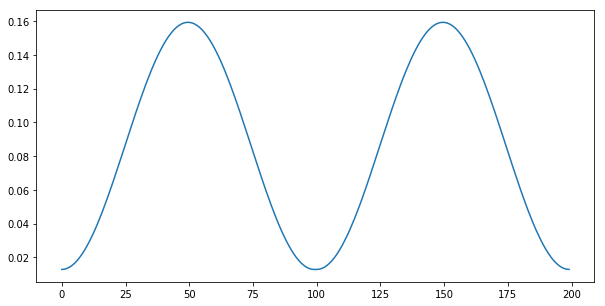


 50%|███████████████████████████████████████▏                                       | 745/1500 [00:37<00:26, 28.49it/s]

In [150]:
plt.figure(figsize=(10, 5))
plt.plot(abs(x[0]))

In [151]:
B = np.block([[0*np.eye(100), np.eye(100)], [np.eye(100), 0*np.eye(100)]])

In [152]:
def f(x, eps=0.9):
    x = x.reshape(-1, 1)
    return np.linalg.norm(A@x - abs(b))**2 + eps*x.T@B@x

In [153]:
temp = []
temp_x = []
for i in tqdm(np.arange(0, 10, 0.1)):
    res = scipy.optimize.minimize(f, x0=np.ones(antenna.N * antenna.n_currents), args=(i, ), bounds=[(0, np.inf) for _ in range(antenna.N * antenna.n_currents)])
    temp.append(*res.fun)
    temp_x.append(res.x)



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:01<01:58,  1.20s/it]

  2%|█▋                                                                                | 2/100 [00:02<01:55,  1.18s/it]

  3%|██▍                                                                               | 3/100 [00:03<01:55,  1.19s/it]

  4%|███▎                                                                              | 4/100 [00:04<01:52,  1.17s/it]

  5%|████                                                                              | 5/100 [00:05<01:54,  1.21s/it]

  6%|████▉                                                                             | 6/100 [00:07<01:55,  1.23s/it]

  7%|█████▋                                                                            | 7/100 [00:08<01:52,  1.21s/it]

  8%|██████▌                  

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:21<00:37,  1.13s/it]

 68%|███████████████████████████████████████████████████████                          | 68/100 [01:22<00:36,  1.14s/it]

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:23<00:35,  1.13s/it]

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:24<00:34,  1.14s/it]

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:25<00:32,  1.13s/it]

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:27<00:31,  1.13s/it]

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:28<00:30,  1.13s/it]

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:28<00:25,  1.04it/s]

 75%|███████████████████████████

In [171]:
np.linalg.norm(A@(res.x).reshape(-1, 1) - b)**2

0.01069004149881636

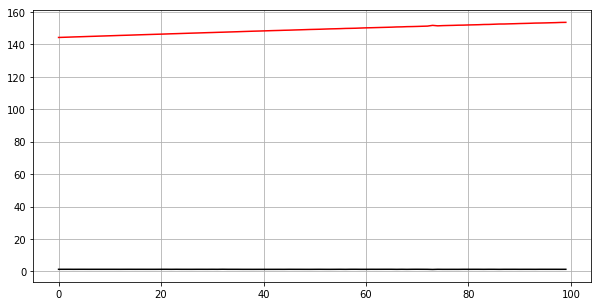

In [155]:
plt.figure(figsize=(10, 5))
plt.plot([np.linalg.norm(x) for x in temp_x], 'k')
plt.plot(temp, 'r')
# plt.ylim([0, 10])
plt.grid(True)

<StemContainer object of 3 artists>

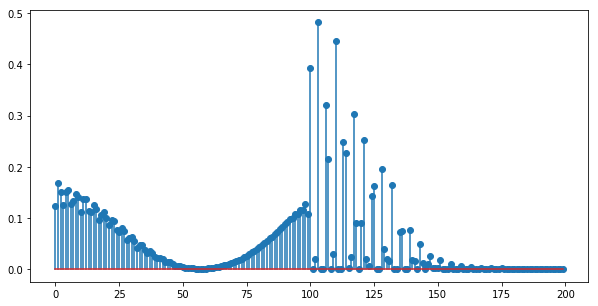

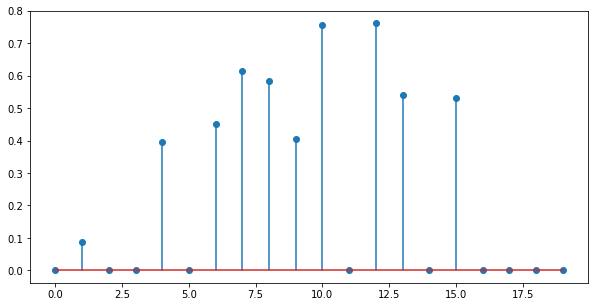

In [156]:
plt.figure(figsize=(10, 5))
plt.stem(res.x)
plt.figure(figsize=(10, 5))
plt.stem(I)

In [84]:
I = [np.array([[0.        ],
        [0.08657657],
        [0.        ],
        [0.        ],
        [0.39541029],
        [0.        ],
        [0.45197912],
        [0.61312728],
        [0.58195155],
        [0.40571744]]), np.array([[0.75519266],
        [0.        ],
        [0.76062757],
        [0.53967791],
        [0.        ],
        [0.53150561],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]])]

In [109]:
I

array([[0.        ],
       [0.08657657],
       [0.        ],
       [0.        ],
       [0.39541029],
       [0.        ],
       [0.45197912],
       [0.61312728],
       [0.58195155],
       [0.40571744],
       [0.75519266],
       [0.        ],
       [0.76062757],
       [0.53967791],
       [0.        ],
       [0.53150561],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [110]:
antenna.objective(np.log(I_))

C:\Users\Sergey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


20.187619007850333

In [157]:
antenna.I = np.split(res.x, 2)

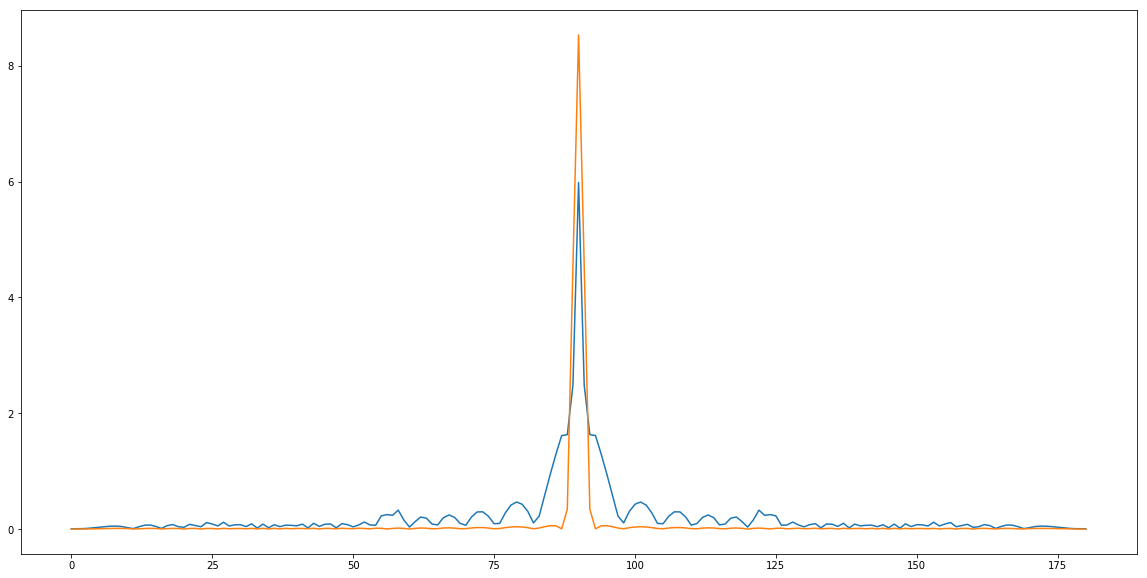

In [162]:
plt.figure(figsize=(20, 10))
plt.plot(abs(antenna.afs[0]@antenna.I[0]))
plt.plot(abs(antenna.beams[0]))